# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

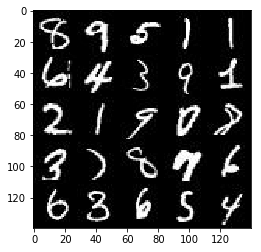

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

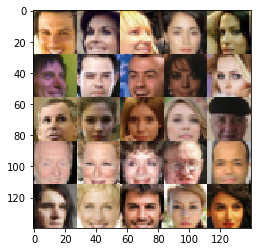

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    # Don't use the same name for a tf placeholder and a variable. It'll create error. 
    learning_rate = tf.placeholder(tf.float32, (None), name='learn_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/joe/anaconda3/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 256, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 * 14 * 256
        
        x2 = tf.layers.conv2d(relu1, 512, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 * 7 * 512
        
        # Flatten and apply sigmoid
        flat = tf.reshape(relu2, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    reuse = False if is_train else True
    
    with tf.variable_scope("generator", reuse=reuse):
        
        # Begin with a fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # First conv layer, after which shape becomes 8 * 8 * 256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
                
        # Second conv layer, after which shape becomes 16 * 16 * 128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
              
        # Third conv layer, after which shape becomes 32 * 32 * 64
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer. shape is 32 * 32 * 3
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        # Resize and apply tanh
        logits = tf.image.resize_images(logits, [28,28])
        out = tf.tanh(logits)        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every = 10
    show_every = 100
    
    tf.reset_default_graph()
        
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)


    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(128, z_dim))

    samples, losses = [], []
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})

                if steps % print_every == 0:
                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    pyplot.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3369... Generator Loss: 1.6572
Epoch 1/2... Discriminator Loss: 0.2050... Generator Loss: 3.6309
Epoch 1/2... Discriminator Loss: 2.9378... Generator Loss: 0.0867
Epoch 1/2... Discriminator Loss: 3.2365... Generator Loss: 0.0999
Epoch 1/2... Discriminator Loss: 1.9133... Generator Loss: 4.3784
Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 1.3934
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 1.4534
Epoch 1/2... Discriminator Loss: 0.4875... Generator Loss: 2.0596
Epoch 1/2... Discriminator Loss: 0.2894... Generator Loss: 2.7204
Epoch 1/2... Discriminator Loss: 0.3817... Generator Loss: 2.8471


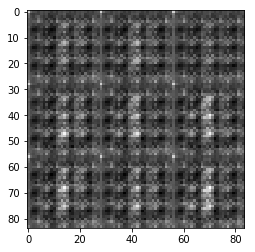

Epoch 1/2... Discriminator Loss: 0.6696... Generator Loss: 1.5926
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 0.4251... Generator Loss: 1.7761
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.0920
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 1.3830
Epoch 1/2... Discriminator Loss: 0.4164... Generator Loss: 1.9324
Epoch 1/2... Discriminator Loss: 0.3298... Generator Loss: 1.8676
Epoch 1/2... Discriminator Loss: 0.8644... Generator Loss: 5.8218
Epoch 1/2... Discriminator Loss: 0.4026... Generator Loss: 2.2718


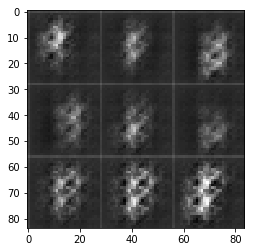

Epoch 1/2... Discriminator Loss: 0.5448... Generator Loss: 3.8740
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 2.8031
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 1.5834
Epoch 1/2... Discriminator Loss: 1.5242... Generator Loss: 0.3654
Epoch 1/2... Discriminator Loss: 0.8105... Generator Loss: 0.9799
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 0.9828
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 1.1811
Epoch 1/2... Discriminator Loss: 0.6896... Generator Loss: 2.6109
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.6038
Epoch 1/2... Discriminator Loss: 0.9430... Generator Loss: 1.7121


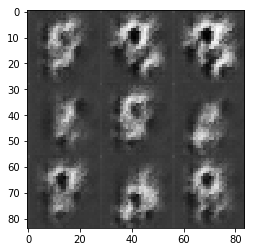

Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 1.2165
Epoch 1/2... Discriminator Loss: 0.7009... Generator Loss: 1.4685
Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 2.0103
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 2.2602
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 2.9023
Epoch 1/2... Discriminator Loss: 0.8887... Generator Loss: 2.0351
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 1.1284
Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 0.5547
Epoch 1/2... Discriminator Loss: 0.6824... Generator Loss: 1.3556


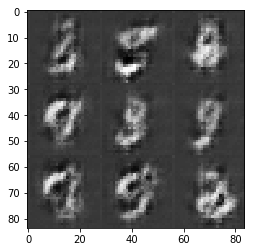

Epoch 1/2... Discriminator Loss: 0.6489... Generator Loss: 1.3185
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 0.6798... Generator Loss: 2.8642
Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 1.6131
Epoch 1/2... Discriminator Loss: 0.4926... Generator Loss: 1.5781
Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 1.5829
Epoch 2/2... Discriminator Loss: 0.4273... Generator Loss: 2.0374
Epoch 2/2... Discriminator Loss: 0.6013... Generator Loss: 1.4965
Epoch 2/2... Discriminator Loss: 0.7198... Generator Loss: 3.3047
Epoch 2/2... Discriminator Loss: 0.5250... Generator Loss: 1.7889


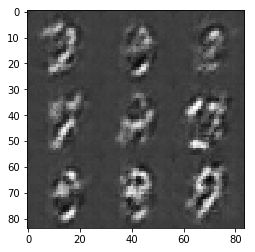

Epoch 2/2... Discriminator Loss: 0.5583... Generator Loss: 1.2561
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 0.8170
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.2737
Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 2.7320
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 1.9419
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 2.3389
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 1.4918
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 3.2573
Epoch 2/2... Discriminator Loss: 0.5664... Generator Loss: 2.0452


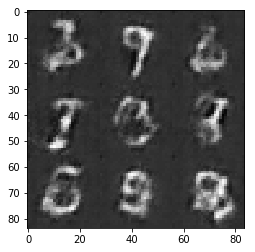

Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 1.1248
Epoch 2/2... Discriminator Loss: 0.5749... Generator Loss: 1.9336
Epoch 2/2... Discriminator Loss: 0.5646... Generator Loss: 2.1671
Epoch 2/2... Discriminator Loss: 0.6413... Generator Loss: 2.2780
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 1.7351
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 2.3985
Epoch 2/2... Discriminator Loss: 0.6836... Generator Loss: 1.1467
Epoch 2/2... Discriminator Loss: 1.6289... Generator Loss: 0.2839
Epoch 2/2... Discriminator Loss: 0.6780... Generator Loss: 1.3006


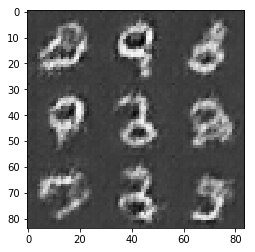

Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 1.7271
Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 0.6860... Generator Loss: 1.5098
Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 1.4266
Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 2.4094
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 0.5143
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 2.3472
Epoch 2/2... Discriminator Loss: 0.6073... Generator Loss: 1.5747
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 3.3290
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 2.8596


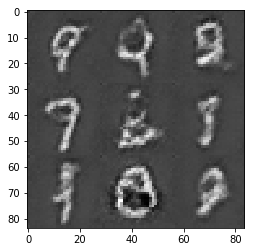

Epoch 2/2... Discriminator Loss: 0.6098... Generator Loss: 1.6300
Epoch 2/2... Discriminator Loss: 0.5574... Generator Loss: 1.8443
Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 2.1436
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.3884
Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 2.0006
Epoch 2/2... Discriminator Loss: 0.6122... Generator Loss: 1.3356
Epoch 2/2... Discriminator Loss: 0.5997... Generator Loss: 1.3259
Epoch 2/2... Discriminator Loss: 0.7344... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 0.6060
Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 3.0498


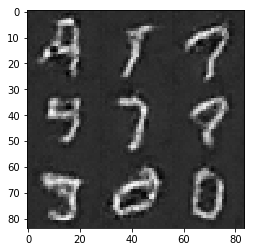

Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 2.1751
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 0.8233


IndexError: list index out of range

In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2610... Generator Loss: 3.6759
Epoch 1/1... Discriminator Loss: 0.2115... Generator Loss: 2.4216
Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 1.8234
Epoch 1/1... Discriminator Loss: 1.7419... Generator Loss: 7.1552
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 2.4363
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 2.3641
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.0429


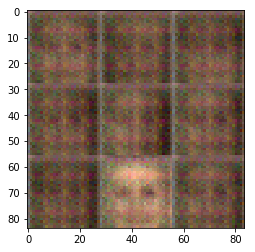

Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 0.5002... Generator Loss: 1.5599
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 1.6472
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.8429
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 2.1975
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.4808
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.3316


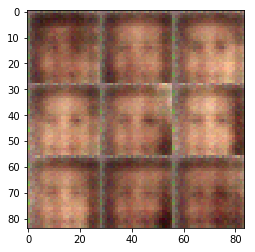

Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 1.5975
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 2.4108
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.4686
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 0.2789... Generator Loss: 2.2618
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.7230
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.5838


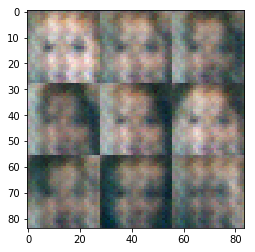

Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.4887
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.3867
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.8562
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 2.0429
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 2.3237
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 0.3136... Generator Loss: 2.4176


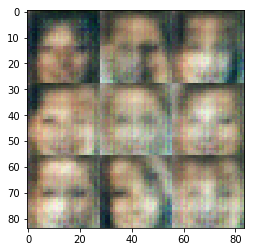

Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 1.5086
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 0.3090... Generator Loss: 5.1789
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 1.8704
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 1.4781
Epoch 1/1... Discriminator Loss: 0.3195... Generator Loss: 3.4993


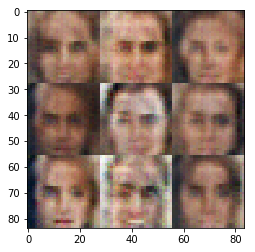

Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.1851
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 2.2246
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 5.2707
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 2.4413
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 3.5089


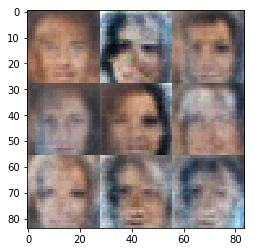

Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.5227
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.3347
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 1.7804
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 1.7274
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 2.1347... Generator Loss: 3.2669
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.5587
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 1.6094


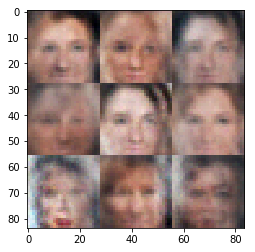

Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 2.4741
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 1.7913
Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 2.0723
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.5140
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.8321
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.5405


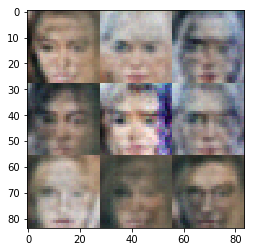

Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.5123
Epoch 1/1... Discriminator Loss: 1.6285... Generator Loss: 2.2852
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.6308
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 0.9799


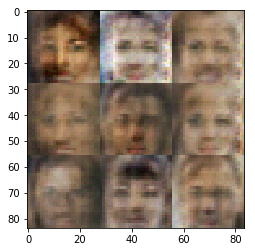

Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 2.0341
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.0732


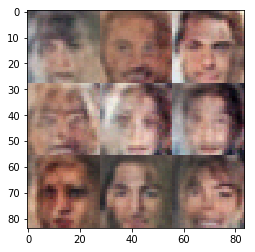

Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.8106
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.2781
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.1101


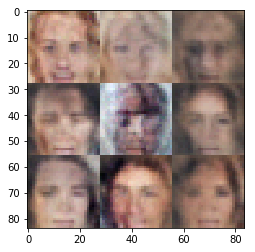

Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.5703
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.8027
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.4929


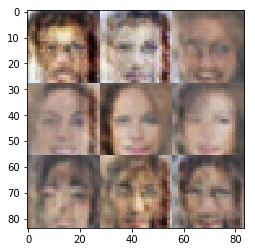

Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 2.2188
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.6874
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 2.0332
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.5073
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.4580
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.2495


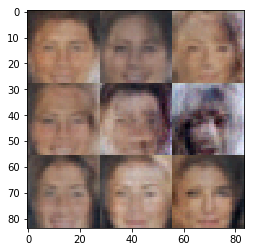

Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 0.7501... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 2.1318
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.5706
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.5108


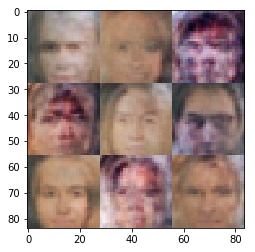

Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.5805
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.6878
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.7601
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.3753
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.5809
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 2.4447
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.3631


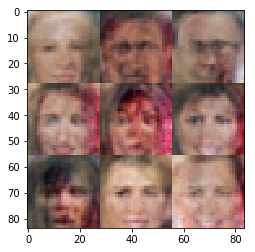

Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.4341
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 2.1904
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 1.6763
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.4962


IndexError: list index out of range

In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.